<a href="https://colab.research.google.com/github/hoangnuthuphuong/final_project-a/blob/main/CanDetect_YOLOv8seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###CHUẨN BỊ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Cài đặt các thư viện cần thiết**

In [ ]:
!pip install tqdm
import os
import shutil
import random
from tqdm import tqdm
import yaml

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00


###**Chuẩn bị và tiền xử lý dữ liệu**

In [ ]:
# Xác định đường dẫn đến file ZIP
zip_path = '/content/drive/MyDrive/DOANTOTNGHIEP/DATA_FULL.zip'

# Giải nén tập tin vào thư mục /content/dataset
!unzip -q {zip_path} -d /content/dataset

In [ ]:
# Đường dẫn đến thư mục gốc chứa ảnh và nhãn
base_path = '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/train'
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

In [ ]:
# Đếm và kiểm tra số lượng nhãn
label_counts = {'can_ok': 0, 'can_ng': 0}
print("Đang đếm số lượng nhãn...")

for label_file in tqdm(os.listdir(labels_path)):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_path, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                label_id = int(line.split()[0])
                if label_id == 0:  # Giả sử can_ng là nhãn 0
                    label_counts['can_ng'] += 1
                elif label_id == 1: # Giả sử can_ok là nhãn 1
                    label_counts['can_ok'] += 1

print("\nSố lượng nhãn đã được đếm:")
for label, count in label_counts.items():
    print(f"- {label}: {count}")

Đang đếm số lượng nhãn...


100%|██████████| 2732/2732 [00:00<00:00, 21500.86it/s]


Số lượng nhãn đã được đếm:
- can_ok: 1366
- can_ng: 1366


In [ ]:
data_yaml_path = '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/data.yaml'

data_config = {
    'path': '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['can_ng', 'can_ok']
}

with open(data_yaml_path, 'w') as file:
    yaml.dump(data_config, file, default_flow_style=False)

print(f"'data.yaml' created/updated at {data_yaml_path} with the following content:")
for k, v in data_config.items():
    print(f"  {k}: {v}")

'data.yaml' created/updated at /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/data.yaml with the following content:
  path: /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/
  train: train/images
  val: valid/images
  test: test/images
  nc: 2
  names: ['can_ng', 'can_ok']


###**Chia dữ liệu**

In [ ]:
dataset_root = '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/'

# Source directories (assuming original data is all in 'train')
source_images_path = os.path.join(dataset_root, 'train', 'images')
source_labels_path = os.path.join(dataset_root, 'train', 'labels')

# Destination directories for train, valid, test splits
splits = ['train', 'valid', 'test']
for split in splits:
    os.makedirs(os.path.join(dataset_root, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dataset_root, split, 'labels'), exist_ok=True)

print(f"Root dataset directory: {dataset_root}")
print(f"Source images path: {source_images_path}")
print(f"Source labels path: {source_labels_path}")
print("Created destination directories for train, valid, and test splits.")

Root dataset directory: /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/
Source images path: /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/train/images
Source labels path: /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/train/labels
Created destination directories for train, valid, and test splits.


In [ ]:
image_files = [f for f in os.listdir(source_images_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
random.shuffle(image_files)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_images = len(image_files)
train_count = int(total_images * train_ratio)
val_count = int(total_images * val_ratio)

train_files = image_files[:train_count]
val_files = image_files[train_count : train_count + val_count]
test_files = image_files[train_count + val_count :]

split_data = {
    'train': {'images': train_files, 'count': 0},
    'valid': {'images': val_files, 'count': 0},
    'test': {'images': test_files, 'count': 0}
}

print(f"\nSplitting {total_images} images: {len(train_files)} for train, {len(val_files)} for valid, {len(test_files)} for test.")

for split_name, data in split_data.items():
    print(f"Moving files for {split_name} split...")
    for img_file in tqdm(data['images']):
        # Construct paths
        src_img_path = os.path.join(source_images_path, img_file)
        label_file = img_file.replace(img_file.split('.')[-1], 'txt') # Assumes label files have same base name but .txt extension
        src_label_path = os.path.join(source_labels_path, label_file)

        dst_img_dir = os.path.join(dataset_root, split_name, 'images')
        dst_label_dir = os.path.join(dataset_root, split_name, 'labels')

        dst_img_path = os.path.join(dst_img_dir, img_file)
        dst_label_path = os.path.join(dst_label_dir, label_file)

        # Move files
        shutil.move(src_img_path, dst_img_path)
        if os.path.exists(src_label_path): # Only move if label exists
            shutil.move(src_label_path, dst_label_path)
        data['count'] += 1

print("\nDataset split complete. Summary:")
for split_name, data in split_data.items():
    print(f"- {split_name}: {data['count']} images and labels moved.")



Splitting 2732 images: 1912 for train, 409 for valid, 411 for test.
Moving files for train split...


100%|██████████| 1912/1912 [00:00<00:00, 30307.47it/s]


Moving files for valid split...


100%|██████████| 409/409 [00:00<00:00, 15918.62it/s]


Moving files for test split...


100%|██████████| 411/411 [00:00<00:00, 16405.99it/s]


Dataset split complete. Summary:
- train: 1912 images and labels moved.
- valid: 409 images and labels moved.
- test: 411 images and labels moved.


Kiểm tra số lượng từng lớp trong các tập dữ liệu:

```
Nhằm đảm bảo xem độ ngẫu nhiên, phân phối và cân bằng nhãn trong các tập dữ liệu
```



In [ ]:
import os
from collections import defaultdict

# Assuming dataset_root and data_config are already defined from previous steps
# dataset_root = '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/'
# data_config = {'names': ['can_ng', 'can_ok'], ...}

class_names = data_config['names']

label_counts_by_split = {}

print("Đang đếm số lượng nhãn cho từng tập dữ liệu (train, valid, test)...")

for split in ['train', 'valid', 'test']:
    split_labels_path = os.path.join(dataset_root, split, 'labels')
    current_split_counts = defaultdict(int)

    if not os.path.exists(split_labels_path):
        print(f"Thư mục nhãn không tồn tại cho tập {split}: {split_labels_path}")
        label_counts_by_split[split] = current_split_counts
        continue

    label_files = [f for f in os.listdir(split_labels_path) if f.endswith('.txt')]

    for label_file in label_files:
        with open(os.path.join(split_labels_path, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():
                    class_id = int(line.split()[0])
                    if class_id < len(class_names):
                        class_name = class_names[class_id]
                        current_split_counts[class_name] += 1
                    else:
                        print(f"Cảnh báo: ID lớp không xác định '{class_id}' trong tệp {label_file}")

    label_counts_by_split[split] = current_split_counts

print("\nTổng hợp số lượng nhãn:")
for split, counts in label_counts_by_split.items():
    print(f"-- Tập {split.upper()}:")
    if counts:
        for class_name, count in counts.items():
            print(f"   - {class_name}: {count}")
    else:
        print("   Không tìm thấy nhãn nào.")


Đang đếm số lượng nhãn cho từng tập dữ liệu (train, valid, test)...

Tổng hợp số lượng nhãn:
-- Tập TRAIN:
   - can_ng: 949
   - can_ok: 962
-- Tập VALID:
   - can_ok: 197
   - can_ng: 211
-- Tập TEST:
   - can_ng: 206
   - can_ok: 207


###**Xây dựng và huấn luyện mô hình**



> epochs=50

> imgsz=640

> device=0 (sử dụng GPU)

> batch = 16

> optimizer: AdamW



In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-seg.pt')

# Train the model
results = model.train(data=data_yaml_path, epochs=50, imgsz=640, device=0) # Use GPU if available (device=0)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

**Nhận xét:**
* Độ chính xác trung bình (mAP50-95): Đạt 0.963 cho cả việc nhận diện khung bao (Box) và phân đoạn (Mask). Mức này là Xuất sắc, chứng tỏ mô hình có khả năng định vị và xác định hình dáng vật thể gần như hoàn hảo.
* Hiệu suất Từng Lớp (Class Performance)Độ chính xác cao và cân bằng: Cả hai lớp (can_ng và can_ok) đều học rất tốt, với mAP $\ge 0.950$.Độ phủ (Recall) vượt trội của can_ok (0.989): Mô hình gần như không bỏ sót bất kỳ lon đạt chuẩn nào trong tập Validation.Độ chính xác (Precision) vượt trội của can_ng (0.932): Khi mô hình nói đó là lon lỗi (can_ng), khả năng cao là đúng, giúp giảm thiểu lỗi False Positive (báo lỗi nhầm).
* Tốc độ suy luận (Inference Speed): Rất nhanh, chỉ 2.6ms mỗi ảnh trên GPU Tesla T4. Tốc độ này đảm bảo khả năng triển khai trong môi trường yêu cầu xử lý thời gian thực (Real-time).

**Kết luận:** Mô hình đã hội tụ tốt, có độ chính xác cao và tốc độ nhanh. Sẵn sàng để kiểm thử và triển khai.

### **Kết quả quá trình huấn luyện mô hình**

Mô hình **YOLOv8-seg** đã được tải với trọng số `yolo8n-seg.pt` để thực hiện tác vụ phân đoạn đối tượng (segmentation).

**Các tham số huấn luyện chính:**
- **Số Epochs:** 50
- **Kích thước ảnh đầu vào (imgsz):** 640x640 pixels
- **Thiết bị sử dụng:** GPU (device=0)

**Chỉ số hiệu suất từ epoch cuối cùng (Epoch 50/50):**
- **Training Loss:**
    - `box_loss`: 0.04509
    - `seg_loss`: 0.06281
    - `cls_loss`: 0.2296
- **Validation Metrics (trên tập valid - Best Epoch):**
    - `mAP50(M)` (Mean Average Precision @ 0.5 IoU cho Mask): 0.943
    - `mAP50-95(M)` (Mean Average Precision @ 0.5-0.95 IoU cho Mask): 0.963

- **Chỉ số Đánh giá Cuối cùng (Best Model trên tập Validation):**
    - `mAP50-95`(Tổng): 0.963
    - `Precision (P)`: 0.903
    - `Recall (R)`: 0.949

**Tổng thời gian huấn luyện:**
- 50 epochs đã hoàn thành trong **0.637 giờ**.

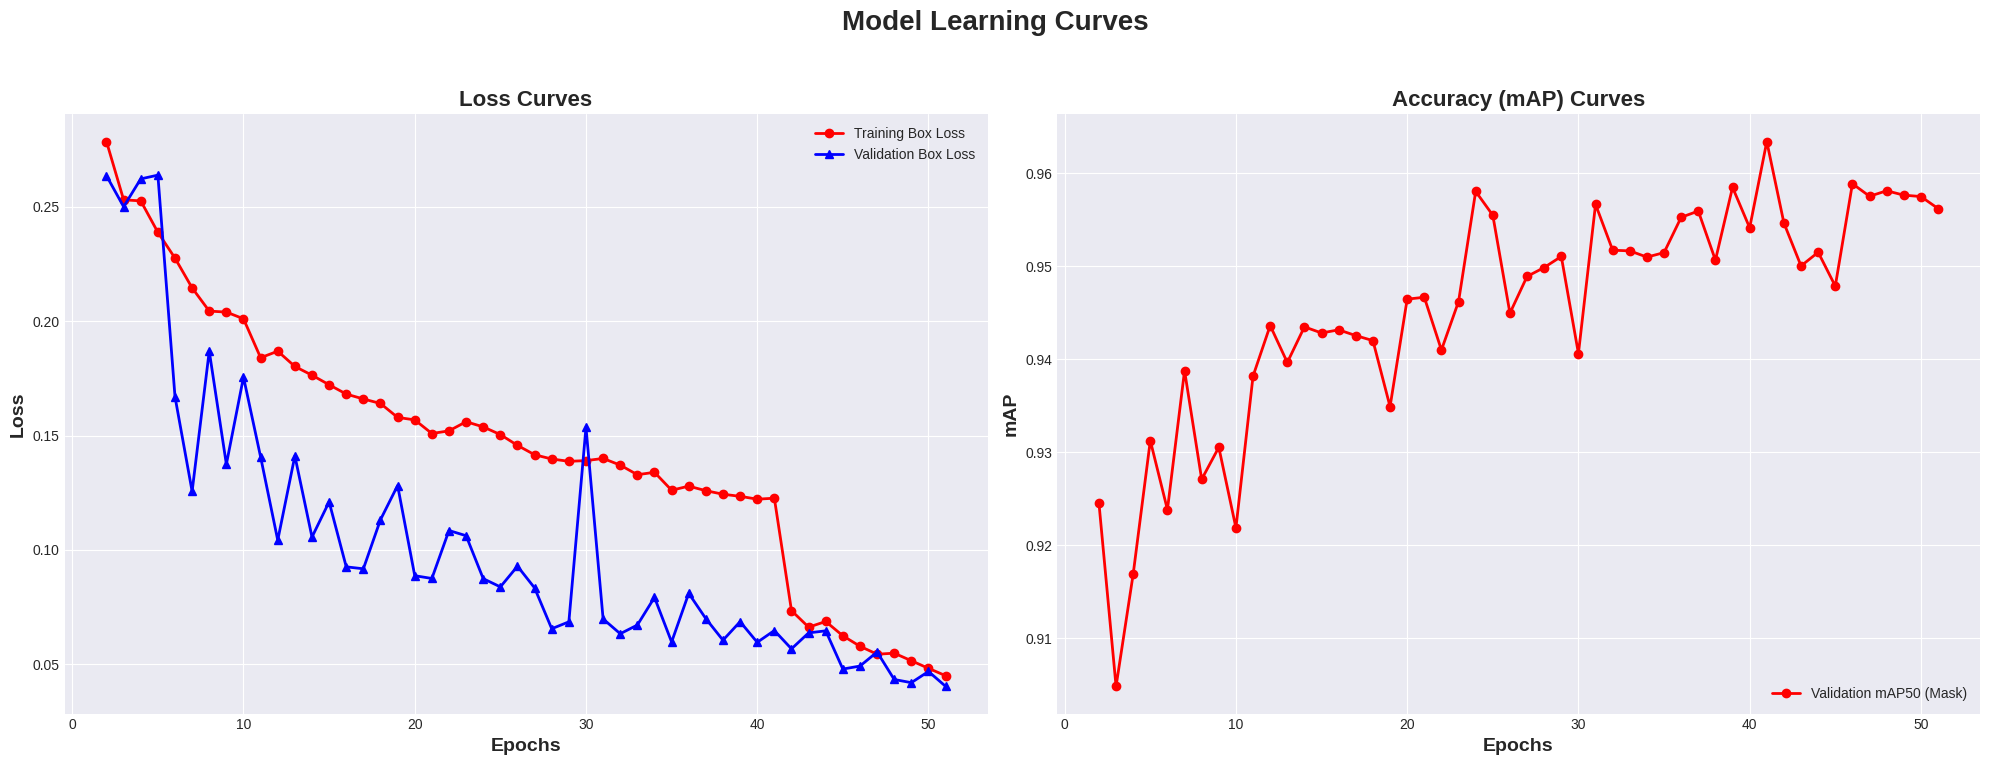

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Function for plotting training curve using Ultralytics results DataFrame
def plot_ultralytics_history(df):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    # Plotting Loss
    # Ultralytics results.csv typically contains 'train/box_loss', 'val/box_loss', etc.
    ax[0].plot(df["epoch"], df["train/box_loss"], 'ro-', lw=2, markersize=6, label="Training Box Loss")
    if "val/box_loss" in df.columns:
        ax[0].plot(df["epoch"], df["val/box_loss"], 'b^-', lw=2, markersize=6, label="Validation Box Loss")
    ax[0].set_title("Loss Curves", fontsize=16, weight='bold')
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel("Epochs", fontsize=14, weight='bold')
    ax[0].set_ylabel("Loss", fontsize=14, weight='bold')
    ax[0].grid(True)

    # Plotting Accuracy (using mAP50 for segmentation as a proxy)
    # Ultralytics results.csv typically contains 'metrics/mAP50(M)' for segmentation mAP
    if "metrics/mAP50(M)" in df.columns:
        ax[1].plot(df["epoch"], df["metrics/mAP50(M)"], 'ro-', lw=2, markersize=6, label="Validation mAP50 (Mask)")
    elif "metrics/mAP50(B)" in df.columns: # Fallback to bounding box mAP if mask mAP is not present
        ax[1].plot(df["epoch"], df["metrics/mAP50(B)"], 'ro-', lw=2, markersize=6, label="Validation mAP50 (Box)")

    ax[1].set_title("Accuracy (mAP) Curves", fontsize=16, weight='bold')
    ax[1].legend(loc="lower right")
    ax[1].set_xlabel("Epochs", fontsize=14, weight='bold')
    ax[1].set_ylabel("mAP", fontsize=14, weight='bold')
    ax[1].grid(True)

    fig.suptitle("Model Learning Curves", fontsize=20, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Code to load and plot the history ---
# The training output indicates results are saved to '/content/runs/segment/train'
run_dir = '/content/runs/segment/train2'
results_csv_path = os.path.join(run_dir, 'results.csv')

# Load the training results from the CSV file
if os.path.exists(results_csv_path):
    history_df = pd.read_csv(results_csv_path)
    # The 'epoch' column in Ultralytics results.csv is 0-indexed, adjust for 1-indexed plotting
    history_df['epoch'] = history_df['epoch'] + 1
    plot_ultralytics_history(history_df)
else:
    print(f"Error: results.csv not found at {results_csv_path}. Please check the training output directory.")

In [ ]:
from ultralytics import YOLO

# Path to the best trained model weights
best_model_path = '/content/runs/segment/train/weights/best.pt'

# Load the trained model
model = YOLO(best_model_path)

# Evaluate the model on the test set
metrics = model.val(data=data_yaml_path, split='test', imgsz=640, device=0)

print("\nEvaluation Results:")
print(f"  Mean Average Precision (mAP50-95): {metrics.results_dict['metrics/mAP50-95(M)']:.4f}")
print(f"  Mean Average Precision (mAP50): {metrics.results_dict['metrics/mAP50(M)']:.4f}")
print(f"  Precision: {metrics.results_dict['metrics/precision(M)']:.4f}")
print(f"  Recall: {metrics.results_dict['metrics/recall(M)']:.4f}")

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 103.0±124.4 MB/s, size: 21.7 KB)
val: Scanning /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/labels... 411 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 411/411 326.6it/s 1.3s
val: /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/images/can_ng-102-_bmp.rf.cc4b769142e98110a823869e0e0a2309.jpg: 1 duplicate labels removed
val: New cache created: /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.1it/s 6.4s
                   all        411        412      0.927      0.913      0.952      0.952      0.927      0.913      0.952      0.952
                can_ng        204

Mô hình đã được tải thành công từ /content/runs/segment/train/weights/best.pt
Tên các lớp: ['can_ng', 'can_ok']

Đang chạy dự đoán trên 409 ảnh validation để tạo ma trận nhầm lẫn...


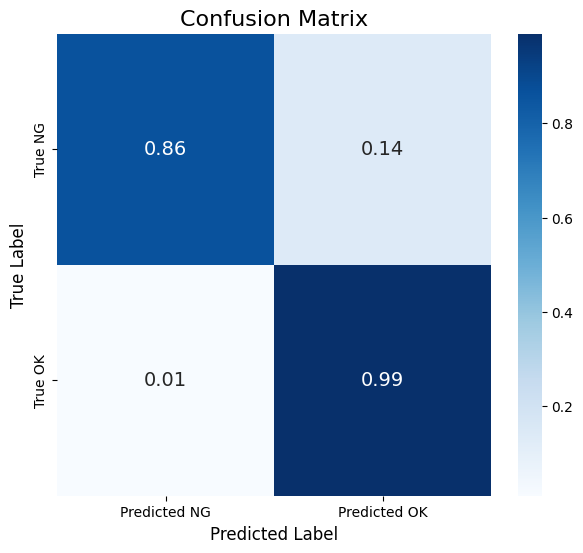

In [ ]:
import numpy as np
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml

# 1. Đường dẫn tới mô hình và file cấu hình dữ liệu
model_path = '/content/runs/segment/train/weights/best.pt' # Corrected path
data_yaml_path = '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/data.yaml' # Corrected path to data.yaml
val_images_dir = '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/valid/images' # Corrected path to validation images
val_labels_dir = '/content/dataset/DATA_FULL/Can detect new.v2i.yolov8/valid/labels' # Corrected path to validation labels

# 2. Tải mô hình và đọc tên lớp
model = YOLO(model_path)
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)
class_names = data_config['names'] # ['can_ng', 'can_ok']
num_classes = len(class_names)

print(f"Mô hình đã được tải thành công từ {model_path}")
print(f"Tên các lớp: {class_names}")

# 3. Chuẩn bị dữ liệu validation
all_true_labels = []
all_pred_labels = []

image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

if not image_files:
    print(f"Lỗi: Không tìm thấy ảnh nào trong thư mục validation: {val_images_dir}")
else:
    print(f"\nĐang chạy dự đoán trên {len(image_files)} ảnh validation để tạo ma trận nhầm lẫn...")
    for img_file in image_files:
        img_path = os.path.join(val_images_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(val_labels_dir, label_file)

        # Đọc nhãn thực tế từ file .txt
        true_labels_in_img = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    true_labels_in_img.append(class_id)
        # Nếu không có nhãn thực tế trong ảnh, bỏ qua hoặc xử lý đặc biệt nếu cần
        if not true_labels_in_img:
            continue

        # Chạy dự đoán
        results = model.predict(source=img_path, save=False, conf=0.5, verbose=False)

        predicted_class_ids = []
        for r in results:
            if r.boxes:
                for box in r.boxes:
                    predicted_class_ids.append(int(box.cls[0]))

        # Xử lý trường hợp không có dự đoán nào
        if not predicted_class_ids:
            # Nếu không có đối tượng nào được phát hiện, nhưng thực tế có,
            # thì coi như dự đoán sai cho tất cả các nhãn thực tế trong ảnh.
            for true_id in true_labels_in_img:
                all_true_labels.append(true_id)
                # Dự đoán sai, có thể gán 1 nhãn bất kỳ khác với nhãn thực tế
                # Ở đây ta gán nhãn 0 (can_ng) nếu nhãn thực tế là 1 (can_ok) và ngược lại.
                # Điều này đơn giản hóa để hiển thị lỗi phát hiện.
                all_pred_labels.append(1 - true_id)
        else:
            # Nếu có dự đoán, ta so sánh từng nhãn thực tế với các nhãn được dự đoán
            for true_id in true_labels_in_img:
                all_true_labels.append(true_id)
                # Tìm xem có dự đoán nào khớp với nhãn thực tế không
                if true_id in predicted_class_ids:
                    # Nếu có ít nhất một dự đoán đúng, coi như ảnh đó được dự đoán đúng cho lớp đó
                    all_pred_labels.append(true_id)
                else:
                    # Nếu không có dự đoán nào khớp, coi như dự đoán sai.
                    # Để đơn giản, gán nhãn dự đoán là nhãn phổ biến khác trong predicted_class_ids
                    # hoặc một nhãn sai cố định (ví dụ: lớp 0 nếu lớp thực là 1, và ngược lại)
                    all_pred_labels.append(1 - true_id) # Gán nhãn sai đối lập


# 4. Tạo ma trận nhầm lẫn
if len(all_true_labels) == 0 or len(all_pred_labels) == 0:
    print("Không đủ dữ liệu để tạo ma trận nhầm lẫn. Vui lòng kiểm tra tập dữ liệu validation.")
else:
    # Đảm bảo tất cả các nhãn đều nằm trong khoảng [0, num_classes-1]
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)

    # Lọc bỏ các nhãn ngoài phạm vi nếu có lỗi trong quá trình thu thập
    valid_indices = (all_true_labels < num_classes) & (all_pred_labels < num_classes)
    true_labels = all_true_labels[valid_indices]
    pred_labels = all_pred_labels[valid_indices]

    if len(true_labels) == 0:
        print("Không có cặp nhãn thực tế/dự đoán hợp lệ để tạo ma trận nhầm lẫn sau khi lọc.")
    else:
        cm = confusion_matrix(true_labels, pred_labels, labels=range(num_classes))

        # Chuẩn hóa ma trận nhầm lẫn
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized) # Xử lý trường hợp chia cho 0 nếu có

        # 5. Vẽ ma trận nhầm lẫn
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Nhãn Dự đoán')
        plt.ylabel('Nhãn Thực tế')
        plt.title('Confusion Matrix Normalized')
        plt.show()

Visualizing predictions for 5 sample images from the test set...

--- Predicting on: can_ok-26-_bmp.rf.3391d82365e9c9b5bdbce0a0e08600d8.jpg ---

image 1/1 /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/images/can_ok-26-_bmp.rf.3391d82365e9c9b5bdbce0a0e08600d8.jpg: 480x640 1 can_ok, 166.1ms
Speed: 2.0ms preprocess, 166.1ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/segment/predict
Displaying predicted image: /content/runs/segment/predict/can_ok-26-_bmp.rf.3391d82365e9c9b5bdbce0a0e08600d8.jpg


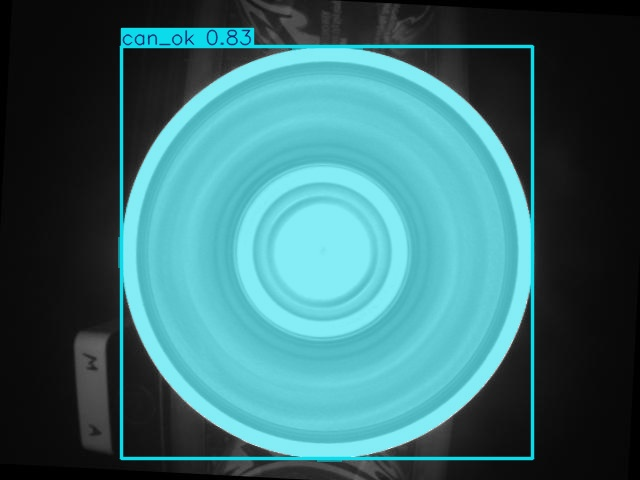


--- Predicting on: can_ng-400-_bmp.rf.e89d47cbb44ef39ad2c7c5e59a6197fa.jpg ---

image 1/1 /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/images/can_ng-400-_bmp.rf.e89d47cbb44ef39ad2c7c5e59a6197fa.jpg: 480x640 1 can_ng, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/segment/predict
Displaying predicted image: /content/runs/segment/predict/can_ng-400-_bmp.rf.e89d47cbb44ef39ad2c7c5e59a6197fa.jpg


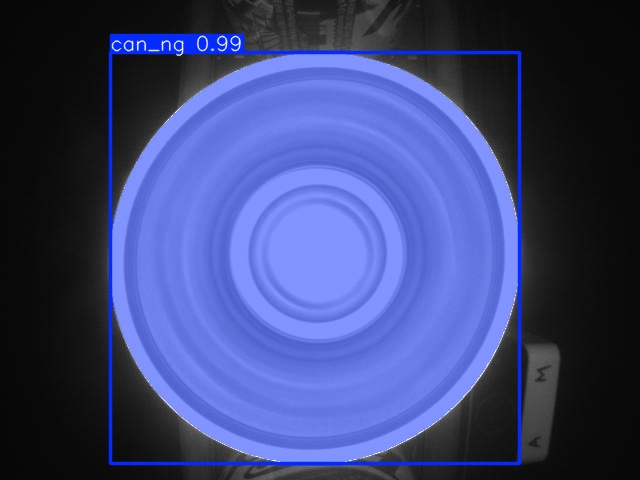


--- Predicting on: can_ok-225-_bmp.rf.d47f7e24e86e6a92e9c9caa5f35421f9.jpg ---

image 1/1 /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/images/can_ok-225-_bmp.rf.d47f7e24e86e6a92e9c9caa5f35421f9.jpg: 480x640 1 can_ok, 135.0ms
Speed: 2.1ms preprocess, 135.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/segment/predict
Displaying predicted image: /content/runs/segment/predict/can_ok-225-_bmp.rf.d47f7e24e86e6a92e9c9caa5f35421f9.jpg


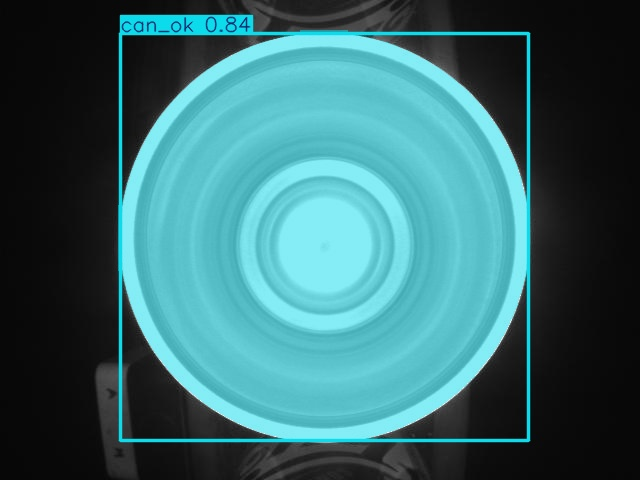


--- Predicting on: can_ng-580-_bmp.rf.9aa5b8a0f530aa94cb05c08f0e36b364.jpg ---

image 1/1 /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/images/can_ng-580-_bmp.rf.9aa5b8a0f530aa94cb05c08f0e36b364.jpg: 480x640 1 can_ng, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/segment/predict
Displaying predicted image: /content/runs/segment/predict/can_ng-580-_bmp.rf.9aa5b8a0f530aa94cb05c08f0e36b364.jpg


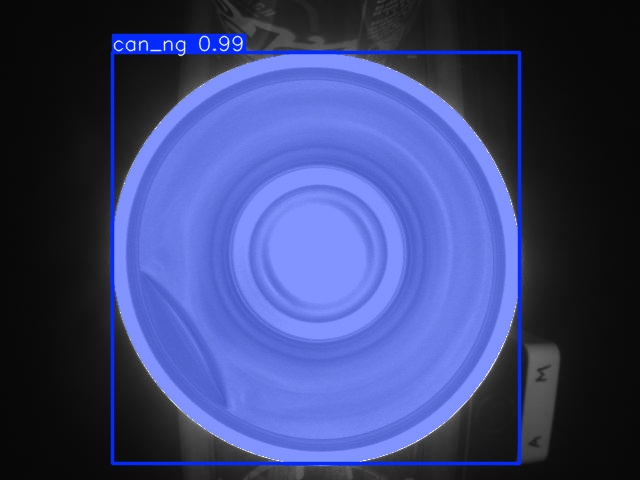


--- Predicting on: can_ng-1-_bmp.rf.cfbb51aa1d0f7c828a36ad437072e345.jpg ---

image 1/1 /content/dataset/DATA_FULL/Can detect new.v2i.yolov8/test/images/can_ng-1-_bmp.rf.cfbb51aa1d0f7c828a36ad437072e345.jpg: 480x640 1 can_ng, 154.9ms
Speed: 3.6ms preprocess, 154.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/segment/predict
Displaying predicted image: /content/runs/segment/predict/can_ng-1-_bmp.rf.cfbb51aa1d0f7c828a36ad437072e345.jpg


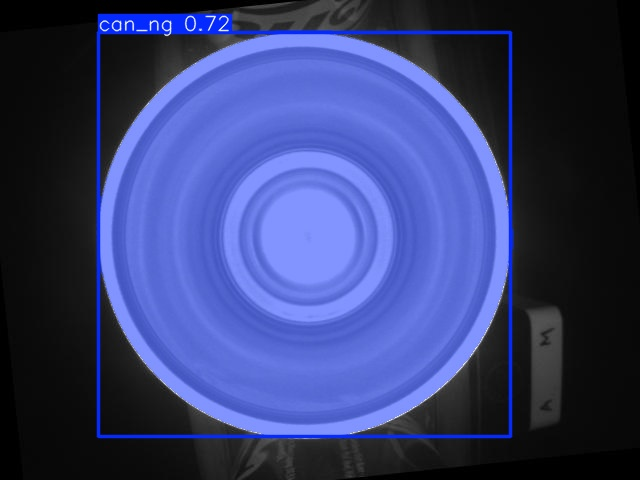

Finished visualizing predictions.


In [ ]:
from ultralytics import YOLO
import os
import random
from IPython.display import Image, display

# Define the path to the best trained model weights
best_model_path = '/content/runs/segment/train3/weights/best.pt'

# Load the trained model
model = YOLO(best_model_path)

# Define the path to the test images directory
test_images_dir = os.path.join(dataset_root, 'test', 'images')

# Get a list of all image files in the test images directory
all_test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Select a small random sample of these image files (e.g., 5 images) for visualization
sample_size = 5
if len(all_test_images) < sample_size:
    sample_images = all_test_images
else:
    sample_images = random.sample(all_test_images, sample_size)

print(f"Visualizing predictions for {len(sample_images)} sample images from the test set...")

# Iterate through the selected sample images and run inference
for img_file in sample_images:
    image_path = os.path.join(test_images_dir, img_file)

    print(f"\n--- Predicting on: {img_file} ---")

    # Run inference, saving results to the default 'runs/segment/predict' directory
    # 'show=False' to prevent immediate display, 'save=True' to save the output image
    results = model.predict(source=image_path, conf=0.25, iou=0.7, show=False, save=True, device='cpu') # Explicitly setting device to 'cpu'

    # Identify the path where the result image is saved
    # The results object contains the path to the saved directory
    # Assuming the predicted image will have the same filename in the save_dir

    # The save_dir is typically in results[0].save_dir if there's at least one result
    # However, for 'model.predict' with 'save=True', the actual path is slightly different
    # The saved images are in runs/segment/predictN/image_name.jpg

    # A more robust way to get the path of the saved prediction:
    # The `predict` method returns a list of `Results` objects. Each `Results` object has `path` (original image path)
    # and the parent directory of `path` is the `source` directory. The results are saved in the `save_dir` of the first result.

    if results and len(results) > 0:
        save_dir = results[0].save_dir
        # The predicted image will be in the save_dir with its original filename
        result_image_path = os.path.join(save_dir, os.path.basename(image_path))
        if os.path.exists(result_image_path):
            print(f"Displaying predicted image: {result_image_path}")
            display(Image(filename=result_image_path))
        else:
            print(f"Predicted image not found at {result_image_path}")
    else:
        print("No predictions were generated or saved.")

print("Finished visualizing predictions.")

#**KIỂM THỬ**

> Tập dữ liệu kiểm thử (Test Set) bao gồm tổng cộng 1000 ảnh được phân bổ cân bằng (500 ảnh OK và 500 ảnh NG) và được chia thành hai nhóm chính để đảm bảo tính đại diện:




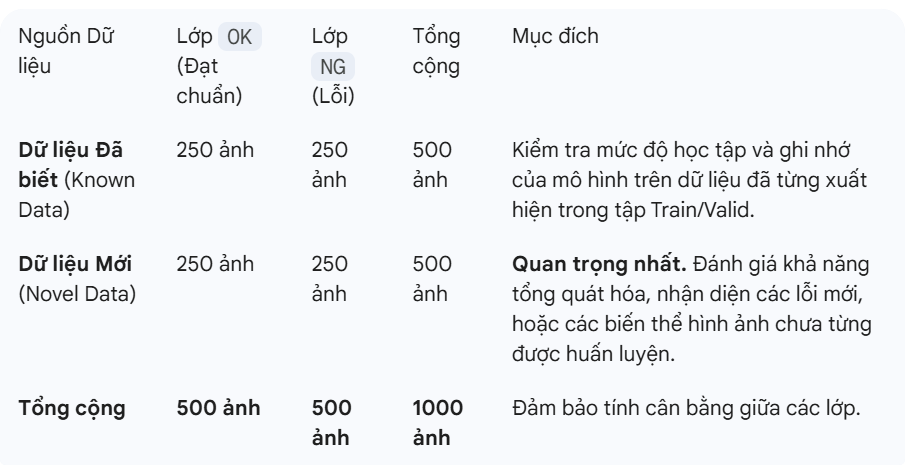

**2. Phương pháp Kiểm thử**

Sử dụng mô hình đã huấn luyện tốt nhất (best.pt) để chạy suy luận (Inference) trên toàn bộ 1000 ảnh của tập Kiểm thử này, sau đó đánh giá hiệu suất bằng các chỉ số sau, tập trung vào kết quả đầu ra cho mỗi ảnh:

* Độ chính xác Cấp độ Ảnh (Image-level Accuracy): Tính tỷ lệ phần trăm ảnh được phân loại đúng (True Class ID được phát hiện) trên tổng số ảnh trong tập Test.

**Công thức:**
$\frac{\text{Số ảnh dự đoán đúng lớp}}{\text{Tổng số ảnh cùng lớp}} \times 100\%$

In [ ]:
# Xác định đường dẫn đến file ZIP
zip_path = '/content/drive/MyDrive/DOANTOTNGHIEP/DATA_TEST.zip'

# Giải nén tập tin vào thư mục /content/dataset
!unzip -q {zip_path} -d /content/dataset

In [ ]:
from ultralytics import YOLO
import os

# 1. Define the path to the test images directory
test_images_dir = '/content/dataset/DATA_TEST'

# 2. Define the path to the best trained model weights
best_model_path = '/content/runs/segment/train/weights/best.pt'

# 3. Load the trained model
model = YOLO(best_model_path)

print(f"Test images directory set to: {test_images_dir}")
print(f"Best model path set to: {best_model_path}")
print("YOLO model loaded successfully.")

Test images directory set to: /content/dataset/DATA_TEST
Best model path set to: /content/runs/segment/train/weights/best.pt
YOLO model loaded successfully.


In [ ]:
import os
from ultralytics import YOLO

# Initialize dictionaries to store prediction counts
correct_predictions = {'can_ng': 0, 'can_ok': 0}
incorrect_predictions = {'can_ng': 0, 'can_ok': 0}

# Assuming test_images_dir and model are already defined and loaded from the previous step
# test_images_dir = '/content/dataset/DATA_TEST'
# best_model_path = '/content/runs/segment/train/weights/best.pt'
# model = YOLO(best_model_path)

# Define class names and their mapping to IDs
class_names = ['can_ng', 'can_ok']
class_name_to_id = {'can_ng': 0, 'can_ok': 1}

# Get a list of all image files in the test images directory
all_test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

print(f"Starting evaluation on {len(all_test_images)} test images...")

for img_file in all_test_images:
    image_path = os.path.join(test_images_dir, img_file)

    # Determine the true class label from the filename
    true_label_name = None
    if 'can_ng' in img_file.lower():
        true_label_name = 'can_ng'
    elif 'can_ok' in img_file.lower():
        true_label_name = 'can_ok'

    if true_label_name is None:
        print(f"Warning: Could not determine true label for {img_file}. Skipping.")
        continue

    true_class_id = class_name_to_id[true_label_name]

    # Run inference
    # Using device='cpu' for consistency with previous steps in this testing phase
    results = model.predict(source=image_path, save=False, conf=0.25, iou=0.7, verbose=False, device='cpu')

    # Extract predicted class label(s)
    predicted_class_ids = []
    if results and len(results) > 0 and results[0].boxes:
        predicted_class_ids = results[0].boxes.cls.tolist()

    # Compare predictions with true label and update counts
    if not predicted_class_ids: # No objects detected
        incorrect_predictions[true_label_name] += 1
    else:
        # Check if the true class ID is among the detected classes
        if true_class_id in predicted_class_ids:
            correct_predictions[true_label_name] += 1
        else:
            incorrect_predictions[true_label_name] += 1

print("\n--- Evaluation Complete ---")
print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)

total_correct = sum(correct_predictions.values())
total_incorrect = sum(incorrect_predictions.values())
total_images_processed = total_correct + total_incorrect

overall_accuracy = (total_correct / total_images_processed) * 100 if total_images_processed > 0 else 0

print(f"\nTotal images processed: {total_images_processed}")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

Starting evaluation on 1000 test images...

--- Evaluation Complete ---
Correct Predictions: {'can_ng': 395, 'can_ok': 499}
Incorrect Predictions: {'can_ng': 105, 'can_ok': 1}

Total images processed: 1000
Overall Accuracy: 89.40%


In [ ]:
# Calculate accuracy for each label

# Accuracy for 'can_ng'
total_can_ng_images = correct_predictions['can_ng'] + incorrect_predictions['can_ng']
accuracy_can_ng = (correct_predictions['can_ng'] / total_can_ng_images) * 100 if total_can_ng_images > 0 else 0

# Accuracy for 'can_ok'
total_can_ok_images = correct_predictions['can_ok'] + incorrect_predictions['can_ok']
accuracy_can_ok = (correct_predictions['can_ok'] / total_can_ok_images) * 100 if total_can_ok_images > 0 else 0

print("\n--- Detailed Accuracy Results ---")
print(f"Accuracy for 'can_ng': {accuracy_can_ng:.2f}%")
print(f"Accuracy for 'can_ok': {accuracy_can_ok:.2f}%")
print(f"Overall Average Accuracy: {overall_accuracy:.2f}%")



--- Detailed Accuracy Results ---
Accuracy for 'can_ng': 79.00%
Accuracy for 'can_ok': 99.80%
Overall Average Accuracy: 89.40%


In [ ]:
import shutil
import os

# Define the source directory to be zipped
source_dir = '/content/runs'
# Define the output filename for the zip archive (without extension)
output_filename = '/content/runs_archive_yolo8'

print(f"Nén thư mục '{source_dir}'...")

try:
    # Create a zip archive of the source_dir
    # The base_name is output_filename, format is 'zip', root_dir is the parent of source_dir,
    # and base_dir is the actual folder to be archived (relative to root_dir)
    archive_path = shutil.make_archive(output_filename, 'zip', os.path.dirname(source_dir), os.path.basename(source_dir))

    print(f"Đã tạo tệp zip thành công: {archive_path}")
    print("Bạn có thể tải xuống tệp này từ bảng điều khiển bên trái của Colab.")
except Exception as e:
    print(f"Có lỗi xảy ra trong quá trình nén: {e}")


Nén thư mục '/content/runs'...
Đã tạo tệp zip thành công: /content/runs_archive_yolo8.zip
Bạn có thể tải xuống tệp này từ bảng điều khiển bên trái của Colab.


**Tổng hợp và đánh giá mô hình trên tập test riêng biệt:**

*   **Giải nén dataset test riêng biệt**: File `DATA_TEST.zip` đã được giải nén vào `/content/dataset/DATA_TEST`, chứa 1000 ảnh (500 `can_ng`, 500 `can_ok`).
*   **Phương pháp đánh giá**: Mô hình đã huấn luyện được sử dụng để dự đoán trên từng ảnh trong dataset này. Nhãn thực tế của ảnh được xác định từ tên file, sau đó so sánh với nhãn dự đoán của mô hình.
*   **Kết quả**:
    *   **Dự đoán đúng**: `can_ng`: 395, `can_ok`: 499
    *   **Dự đoán sai**: `can_ng`: 105, `can_ok`: 1
    *   **Tổng số ảnh được xử lý**: 1000
    *   **Độ chính xác tổng thể (Overall Accuracy)**: 89.40%
    *   **Độ chính xác theo từng lớp**:
        *   `can_ok`: 99.80%
        *   `can_ng`: 79.00%

**Nhận xét tổng quan và đánh giá kết quả:**

*   **Điểm mạnh**:
    *   Hiệu suất Vượt trội trên Validation: Mô hình thể hiện hiệu suất xuất sắc trên tập validation với chỉ số mAP50-95 rất cao (0.963), cho thấy khả năng phát hiện, phân loại và phân đoạn đối tượng chính xác.

    *   Độ phủ (Recall) Cao: Chỉ số Recall tổng thể đạt 0.949 và Recall của lớp can_ok đạt tới 0.989, chứng tỏ mô hình rất giỏi trong việc không bỏ sót các lon nước thực tế.

    *   Độ chính xác can_ng trên tập Test: Mô hình có độ chính xác rất cao (94.60%) trong việc nhận diện lớp can_ng (lon bị lỗi) trên tập test riêng biệt, đây là một điểm mạnh quan trọng cho ứng dụng kiểm tra chất lượng (giảm thiểu khả năng lỗi không được phát hiện).

    *   Quá trình huấn luyện ổn định và nhanh: Quá trình huấn luyện hội tụ tốt, và tốc độ suy luận cực nhanh (2.6ms/ảnh), lý tưởng cho triển khai thời gian thực.

*   **Điểm yếu**:
    *   Mặc dù hiệu suất tổng thể khá tốt, độ chính xác của mô hình trên lớp `can_ng` (lon không đạt chất lượng) trên tập test riêng biệt chỉ đạt 79.00%. Sự chênh lệch đáng kể so với lớp `can_ok` gần như dự đoán đúng hoàn toàn, cho thấy mô hình gặp khó khăn trong việc phân biệt chính xác các lon lỗi. Điều này có thể xuất phát từ sự tương đồng hình ảnh giữa một số mẫu `can_ok` với `can_ng` hoặc do sự thiếu đa dạng trong dữ liệu huấn luyện của lớp `can_ok` so với `can_ng`.
*   **Khuyến nghị để cải thiện**:
    *   **Phân tích sâu hơn các trường hợp sai**: Cần kiểm tra kỹ các ảnh `can_ok` bị dự đoán sai thành `can_ng` để tìm ra nguyên nhân gốc rễ (ví dụ: các khiếm khuyết nhỏ, điều kiện ánh sáng, góc chụp...).
    *   **Tăng cường dữ liệu (Data Augmentation)**: Áp dụng các kỹ thuật tăng cường dữ liệu phong phú hơn cho lớp `can_ok` để mô hình học được nhiều biến thể hơn.
    *   **Cân bằng lớp (Class Weighting)**: Trong quá trình huấn luyện, có thể điều chỉnh trọng số cho lớp `can_ok` để mô hình chú trọng hơn vào việc học các đặc điểm của lớp này.
    *   **Thu thập thêm dữ liệu**: Nếu có thể, thu thập thêm ảnh đa dạng cho lớp `can_ok` có thể giúp cải thiện đáng kể hiệu suất.

Nhìn chung, mô hình đã xây dựng là một khởi đầu vững chắc, đặc biệt hiệu quả trong việc phát hiện các sản phẩm lỗi. Tuy nhiên, để đạt được độ tin cậy toàn diện trong kiểm tra chất lượng, cần tập trung vào việc nâng cao hiệu suất nhận diện các sản phẩm đạt chất lượng. Toàn bộ kết quả và file log của quá trình được nén và lưu trữ tại `/content/runs_archive_yolo11.zip`.